# Application of GloVe on top of Lemmatization -- feature extractions -- Model Building

### Intro :
> GloVe, which stands for Global Vectors for Word Representation, is an unsupervised learning algorithm for generating word embeddings. Word embeddings are dense vector representations of words or phrases that capture semantic and syntactic relationships between them. The GloVe algorithm was developed by researchers at Stanford University in 2014.

### Idea of GloVe
> The main idea behind GloVe is to leverage statistics of word co-occurrence in a large corpus to learn word embeddings. It takes into account both global word co-occurrence patterns as well as local word co-occurrences within a specific context window. By analyzing these patterns, GloVe constructs a low-dimensional vector space representation where words with similar meanings or contexts are closer together.

### Training
> GloVe training involves constructing a co-occurrence matrix that records the frequency of word co-occurrences. This matrix is then factorized using matrix factorization techniques, such as singular value decomposition (SVD), to obtain word embeddings. The resulting word vectors capture both semantic relationships, such as analogies (e.g., "king" - "man" + "woman" ≈ "queen"), and syntactic relationships, such as verb tense transformations.

## Import Required Libraries

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import f1_score, classification_report, confusion_matrix,accuracy_score

## We can also use Lemmatizer instead of Stemmer
lemmatizer = WordNetLemmatizer()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import nltk
nltk.download('stopwords')
# Downloading wordnet before applying Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

import distance
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from fuzzywuzzy import fuzz

## Loading the DataFrame

In [16]:
df = pd.read_csv(r"C:\Users\sanja\Downloads\train.csv\train.csv")

In [17]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [18]:
df.shape

(404290, 6)

In [19]:
df = df.dropna(how="any").reset_index(drop=True)

In [20]:
df.shape

(404287, 6)

<AxesSubplot:xlabel='is_duplicate'>

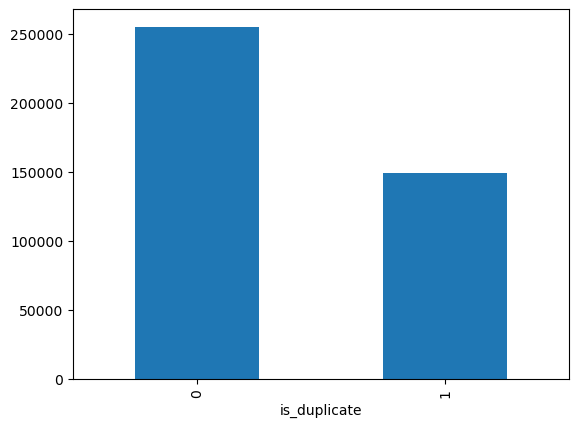

In [21]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [22]:
df['is_duplicate'].value_counts(normalize = True)

0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64

- Similar question pair - 36.92%

- Non-Similar question pair - 63.07%

In [23]:
#Number of Unique Questions

qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}\n'.format(unique_qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qids*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))


Total number of  Unique Questions are: 537929

Number of unique questions that appear more than one time: 111778 (20.779322178205675%)

Max number of times a single question is repeated: 157



### Feature Engineering

Feature engineering is a way where we come up with meaningful features from the already existing features. There is a lot of scope for feature engineering in this project. Let's explore and find ways in which we can find the similarity between two questions.

## Text to Numerical vectors - GloVe
* Step 1 - Load `GloVe` model from `gensim.downloader`
* Step 2 - Convert the sentences to the List of Words (i.e. List of Tokens)
* Step 3 - Use GloVe to learn numerical vectors for each `unique words`. GloVe uses the list of tokens and generate 300 Dimensional numerical vector for each unique word.
* Step 4 - Convert the word vectors to document vectors.

## Loading GloVe Model - `glove-wiki-gigaword-300`

In [34]:
import gensim
import gensim.downloader as api

print(gensim.__version__)

print(list(gensim.downloader.info()['models'].keys()))

4.1.2
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [35]:
wv = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [36]:
def sent2vec(s):
    words = str(s).lower() #lower the sentence
    words = word_tokenize(words) #tokenize the sentence
    words = [w for w in words if not w in stop_words] #Filter out the stop words
    words = [w for w in words if w.isalpha()] #Filter out non-alpha characters
    M = []
    for w in words:#loop through each word in the sentence
        try:
            M.append(wv[w])#Gensim model converts each word in the sentence to a 300-dim vector space and appends to a list.
        except:
            continue
    M = np.array(M) #convert the list to array. Shape = (num_of_words_in_sentence,300)
    v = M.sum(axis=0) #Sum up along the num_of_words_in_sentence through 300-dim. Shape = (1,300) 
    return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum

In [37]:
from tqdm import tqdm_notebook #for parallel processing

question1_vectors = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 1
for i, q in enumerate(tqdm_notebook(df.question1.values)):
    question1_vectors[i, :] = sent2vec(q) #function call for each question 1
    
question2_vectors  = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 2
for i, q in enumerate(tqdm_notebook(df.question2.values)):
    question2_vectors[i, :] = sent2vec(q) #function call for each question 2

C:\Users\sanja\AppData\Local\Temp\ipykernel_19476\2845859528.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/404287 [00:00<?, ?it/s]

C:\Users\sanja\AppData\Local\Temp\ipykernel_19476\1224922019.py:14: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\sanja\AppData\Local\Temp\ipykernel_19476\2845859528.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/404287 [00:00<?, ?it/s]

In [38]:
question1_vectors[:1] #300-dim vector representing the first question in question 1 coulumn.

array([[-1.08395414e-02, -2.90429182e-02,  3.54171544e-02,
        -4.13848199e-02,  3.01641249e-03, -3.33982967e-02,
        -2.47308966e-02,  5.75867034e-02,  4.06110054e-03,
        -4.18411821e-01,  3.83711569e-02, -2.76007373e-02,
        -4.83873561e-02,  9.28274542e-03,  3.07396017e-02,
        -9.44911502e-03, -1.09569348e-01, -5.36292195e-02,
         3.75382346e-03, -6.09081574e-02, -4.78154384e-02,
         2.30828393e-02,  5.47099523e-02,  7.61645883e-02,
        -4.46026213e-02,  8.97757336e-03,  1.06527389e-03,
         5.67277521e-02,  2.60279933e-03, -1.90211032e-02,
        -3.84894721e-02,  2.74615530e-02,  2.29211641e-03,
         2.50090733e-02, -2.34096408e-01,  7.30602890e-02,
        -3.52953025e-03,  5.14153810e-03, -4.61917594e-02,
        -3.08898129e-02,  2.05976907e-02, -6.11264212e-03,
        -5.44249564e-02,  7.53159970e-02, -4.71173674e-02,
        -5.58066554e-02,  4.09591384e-02,  5.78902438e-02,
        -4.16707098e-02, -2.50221859e-03,  3.66747342e-0

## Let's do feature engineering to extract distances

### Cosine distance

* It is the compliment of the cosine similarity. Cosine similarity finds the angle between two text vectors in higher dimensional space. If cos(theta) is small then the cosine distance is large and vice-versa. Hence Inversly proportional. 
> Cosine distance = 1 - Cosine similarity

### Mahattan or City-block distance

Manhattan Distance is preferred over the Euclidean distance metric as the dimension of the data increases. This occurs due to something known as the ‘curse of dimensionality’.

### Jaccard distance

It is defined as size of intersection divided by size of union of two sets.

### Fuzz_ratio

It is a ratio function that computes the standard Levenshtein distance similarity ratio between two sequences.

### Fuzz_partial_ratio

This function allows us to perform substring matching. This works by taking the shortest string and matching it with all substrings that are of the same length.

### Fuzz_token_sort_ratio

This function sorts the strings alphabetically and then joins them together. Then, the fuzz.ratio() is calculated. This can come in handy when the strings you are comparing are the same in spelling but are not in the same order.

### Fuzz_token_set_ratio

The token_set_ratio() function is similar to the token_sort_ratio() function above, except it takes out the common tokens before calculating the fuzz.ratio() between the new strings. This function is the most helpful when applied to a set of strings with a significant difference in lengths.

In [39]:
df['len_q1'] = df.question1.apply(lambda x: len(str(x)))
df['len_q2'] = df.question2.apply(lambda x: len(str(x)))
df['common_words'] = df.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:620: RuntimeWarning:

invalid value encountered in double_scalars

C:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:1155: RuntimeWarning:

invalid value encountered in double_scalars



In [40]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,...,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,...,92,100,93,0.033067,3.562469,1.0,89.439283,0.257166,0.115104,0.159782
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,...,82,91,64,0.504745,13.048161,1.0,183.543221,1.004734,0.507498,0.613816
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,...,80,67,67,0.190421,8.554435,1.0,148.870227,0.617124,0.276275,0.372139
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,...,29,28,25,0.546846,14.241201,1.0,192.699511,1.045798,0.478082,0.667696
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,...,71,63,48,0.293943,10.575400,1.0,167.870487,0.766738,0.351893,0.471646


In [41]:
df.to_csv(r"C:\Users\sanja\Downloads\train.csv\updated.csv") 

In [42]:
df = pd.read_csv(r"C:\Users\sanja\Downloads\train.csv\updated.csv")

In [43]:
df.head(2)

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,...,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,...,92,100,93,0.033067,3.562469,1.0,89.439283,0.257166,0.115104,0.159782
1,1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,...,82,91,64,0.504745,13.048161,1.0,183.543221,1.004734,0.507498,0.613816


In [44]:
df.drop(['Unnamed: 0','id','qid1','qid2','question1','question2'],axis = 1,inplace = True)

In [45]:
df.head(2)

,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,47,41,5,93,98,100,92,100,93,0.033067,3.562469,1.0,89.439283,0.257166,0.115104,0.159782
1,0,41,77,3,66,85,100,82,91,64,0.504745,13.048161,1.0,183.543221,1.004734,0.507498,0.613816


In [46]:
df.shape

(404287, 17)

In [47]:
df.dropna(axis = 0,inplace = True)

In [48]:
X = df.iloc[:,1:]

In [49]:
y = df['is_duplicate']

In [51]:
df = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_partial_token_sort_ratio','fuzz_token_set_ratio','fuzz_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','jaccard_distance','euclidean_distance',
                'minkowski_distance','is_duplicate']] # Reanrrange the features

In [52]:
y = df['is_duplicate'] # Seggregating the data to input and output
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_partial_token_sort_ratio','fuzz_token_set_ratio','fuzz_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

In [53]:
from sklearn.model_selection import train_test_split # Test - Train 
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
X_train_num = X_train.select_dtypes(include = ['int64', 'float64']) # segregating the Numerical feature

In [55]:
# scaling the numerical features on the Training Data
from sklearn.preprocessing import StandardScaler

Std_scaler = StandardScaler()

# feature names will be (annoyingly) lost after Scaling the data
# (i.e. the dataframe is converted to a numpy ndarray)

X_train_trns = pd.DataFrame(Std_scaler.fit_transform(X_train_num),
                                     columns = X_train_num.columns,
                                     index = X_train_num.index)
X_train_trns.head()

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,euclidean_distance,minkowski_distance
165624,-0.012271,0.846044,1.120750,0.711166,0.358029,1.098278,0.980195,0.673491,-0.485723,-0.746500,-0.661773,-0.699743,-0.730799
253997,-0.960799,-0.593752,-1.417369,-1.070557,-1.248901,-2.205009,-2.043991,-1.766669,0.508653,0.529591,0.699415,0.700965,0.721691
153684,-0.960799,-0.429204,-1.417369,-1.344668,-1.870938,-1.934247,-2.450224,-2.205898,1.658174,3.510638,2.594428,2.524761,2.417194
59494,0.574913,0.023303,0.105503,-0.750760,-1.145228,-0.580441,-0.735015,-0.546589,0.065310,-0.331194,-0.104539,-0.127094,-0.146956
108477,-0.599455,0.640359,0.613127,0.025888,0.409865,-0.417984,0.754509,-0.204967,-0.169740,-0.466803,-0.275858,-0.293189,-0.330261


In [56]:
X_test_num = X_test.select_dtypes(include = ['int64', 'float64']) # segregating the Numerical feature

In [57]:
X_test_trns = pd.DataFrame(Std_scaler.transform(X_test_num),
                                    columns = X_test_num.columns,
                                    index = X_test_num.index)
X_test_trns.head()

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,canberra_distance,cosine_distance,cityblock_distance,euclidean_distance,minkowski_distance
344164,-0.554287,-0.634889,-0.909745,-0.705075,-1.093391,-0.851202,-0.780152,-0.400179,0.192572,0.190375,0.360649,0.408458,0.421946
98151,-0.102607,2.491525,-0.909745,-0.933501,-0.575027,-1.176116,-1.637757,-1.473850,1.276019,1.433282,1.403987,1.359154,1.278968
36619,0.845921,0.558085,1.120750,-0.065482,-0.471354,0.881669,0.980195,1.112720,0.363172,0.349979,0.616414,0.550220,0.474133
200148,0.213569,1.010592,0.613127,-0.156853,-0.678700,-0.417984,0.258001,0.234262,0.222834,0.106767,0.346994,0.330800,0.299557
268056,0.710417,-0.922848,-0.402121,-0.568020,-0.367681,0.448451,0.167727,-0.644195,0.419603,0.221090,0.411577,0.436372,0.449014


## Model Building

## LogisticRegression

In [58]:
from sklearn.linear_model import LogisticRegression
cls = LogisticRegression()
cls.fit(X_train_trns, y_train)

# prediction on train
y_train_pred = cls.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

# prediction on test
y_test_pred = cls.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

---------- Prediction on train ----------
[[135329  43121]
 [ 46892  57361]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75    178450
           1       0.57      0.55      0.56    104253

    accuracy                           0.68    282703
   macro avg       0.66      0.65      0.66    282703
weighted avg       0.68      0.68      0.68    282703

---------- Prediction on test ----------
[[57850 18324]
 [20477 24508]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     76174
           1       0.57      0.54      0.56     44985

    accuracy                           0.68    121159
   macro avg       0.66      0.65      0.65    121159
weighted avg       0.68      0.68      0.68    121159



## RidgeClassifier

In [59]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier

tuned_parameters = [{'alpha':[x for x in range(1,10)]}]

clf = GridSearchCV(
    estimator=RidgeClassifier(), 
    param_grid=tuned_parameters, 
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)
clf.fit(X_train_trns, y_train)

print("Best parameters set found on train set:")
print(clf.best_params_)
print(clf.best_estimator_)

y_p = clf.predict(X_test_trns)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters set found on train set:
{'alpha': 2}
RidgeClassifier(alpha=2)


In [61]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [62]:
# Evaluating the model using the Evaluation metrics
print(f1_score(y_test, y_p)) 
print(classification_report(y_test, y_p))

0.541774180245779
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     76174
           1       0.58      0.51      0.54     44985

    accuracy                           0.68    121159
   macro avg       0.65      0.64      0.65    121159
weighted avg       0.67      0.68      0.67    121159



## AdaBoostClassifier

In [63]:
from sklearn.ensemble import AdaBoostClassifier
cls1 = AdaBoostClassifier()
cls1.fit(X_train_trns, y_train)

# prediction on train
y_train_pred1 = cls1.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred1))
print(classification_report(y_train, y_train_pred1))

# prediction on test
y_test_pred1 = cls1.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred1))
print(classification_report(y_test, y_test_pred1))

---------- Prediction on train ----------
[[133263  45187]
 [ 33784  70469]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77    178450
           1       0.61      0.68      0.64    104253

    accuracy                           0.72    282703
   macro avg       0.70      0.71      0.71    282703
weighted avg       0.73      0.72      0.72    282703

---------- Prediction on test ----------
[[57012 19162]
 [14556 30429]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77     76174
           1       0.61      0.68      0.64     44985

    accuracy                           0.72    121159
   macro avg       0.71      0.71      0.71    121159
weighted avg       0.73      0.72      0.72    121159



## GradientBoostingClassifier

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
cls2 = GradientBoostingClassifier()
cls2.fit(X_train_trns, y_train)

# prediction on train
y_train_pred2 = cls2.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred2))
print(classification_report(y_train, y_train_pred2))

# prediction on test
y_test_pred2 = cls2.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred2))
print(classification_report(y_test, y_test_pred2))

---------- Prediction on train ----------
[[132622  45828]
 [ 27801  76452]]
              precision    recall  f1-score   support

           0       0.83      0.74      0.78    178450
           1       0.63      0.73      0.67    104253

    accuracy                           0.74    282703
   macro avg       0.73      0.74      0.73    282703
weighted avg       0.75      0.74      0.74    282703

---------- Prediction on test ----------
[[56694 19480]
 [12161 32824]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78     76174
           1       0.63      0.73      0.67     44985

    accuracy                           0.74    121159
   macro avg       0.73      0.74      0.73    121159
weighted avg       0.75      0.74      0.74    121159



## XGBClassifier

In [65]:
from xgboost import XGBClassifier
cls3 = XGBClassifier()
cls3.fit(X_train_trns, y_train)

# prediction on train
y_train_pred3 = cls3.predict(X_train_trns)

print('-'*10,'Prediction on train','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_train, y_train_pred3))
print(classification_report(y_train, y_train_pred3))

# prediction on test
y_test_pred3 = cls3.predict(X_test_trns)

print('-'*10,'Prediction on test','-'*10)
# Evaluating the model using the Evaluation metrics
print(confusion_matrix(y_test, y_test_pred3))
print(classification_report(y_test, y_test_pred3))

---------- Prediction on train ----------
[[140894  37556]
 [ 25572  78681]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82    178450
           1       0.68      0.75      0.71    104253

    accuracy                           0.78    282703
   macro avg       0.76      0.77      0.77    282703
weighted avg       0.78      0.78      0.78    282703

---------- Prediction on test ----------
[[58959 17215]
 [12497 32488]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     76174
           1       0.65      0.72      0.69     44985

    accuracy                           0.75    121159
   macro avg       0.74      0.75      0.74    121159
weighted avg       0.76      0.75      0.76    121159



## StackingClassifier

In [66]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
estimators = [
    ('LR', LogisticRegression()),
    ("GNB",GaussianNB()),
    ('DT',DecisionTreeClassifier(random_state=42),
    'XGb',XGBClassifier(),
      'RC',RidgeClassifier(),
     'RF',RandomForestClassifier(),
     'GBDT',GradientBoostingClassifier())
]

stack_cls = StackingClassifier(estimators=estimators,
                                      final_estimator=XGBClassifier())

stack_cls.fit(X_train_trns, y_train)


# Prediction on test data
y_test_pred4 = stack_cls.predict(X_test_trns)

print('-'*10,'on test','-'*10)
# Evaluation on test data
print(confusion_matrix(y_test, y_test_pred4))
print(classification_report(y_test, y_test_pred4))

---------- on test ----------
[[60806 15368]
 [18673 26312]]
              precision    recall  f1-score   support

           0       0.77      0.80      0.78     76174
           1       0.63      0.58      0.61     44985

    accuracy                           0.72    121159
   macro avg       0.70      0.69      0.69    121159
weighted avg       0.72      0.72      0.72    121159



## Serialization of the model's

In [67]:
from pickle import dump

dump(cls, open(r"C:\Users\sanja\Downloads\train.csv\LR_cls.pkl", 'wb'))
dump(stack_cls, open(r"C:\Users\sanja\Downloads\train.csv\stack_cls.pkl", 'wb'))
dump(clf, open(r"C:\Users\sanja\Downloads\train.csv\LR_HYP.pkl", 'wb'))
dump(cls1, open(r"C:\Users\sanja\Downloads\train.csv\ADA_cls.pkl", 'wb'))
dump(cls2, open(r"C:\Users\sanja\Downloads\train.csv\GBDT_cls.pkl", 'wb'))
dump(cls3, open(r"C:\Users\sanja\Downloads\train.csv\XGB_cls.pkl", 'wb'))

## calibration_curve

In [68]:
from sklearn.calibration import calibration_curve

C:\Users\sanja\AppData\Roaming\Python\Python39\site-packages\sklearn\calibration.py:1000: FutureWarning:

The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).



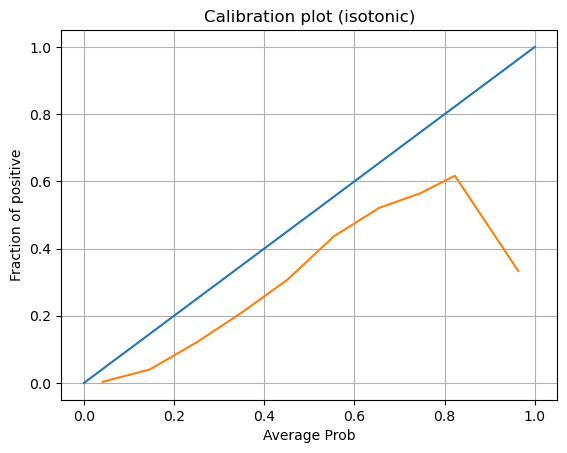

In [70]:
clf = SGDClassifier(penalty = 'l2',alpha = 0.0001,tol = 0.01,loss = 'log_loss')
calibrated_model = CalibratedClassifierCV(clf,method = 'isotonic',cv = 5)
calibrated_model.fit(X_train,y_train)
prob = calibrated_model.predict_proba(X_test)[:,1] #for one of the class
fop,apv  = calibration_curve(y_test,prob,n_bins = 10,normalize = True)
plt.plot([0,1],[0,1])
plt.plot(apv,fop)
plt.grid()
plt.xlabel("Average Prob")
plt.ylabel("Fraction of positive")
plt.title('Calibration plot (isotonic)')
plt.show()
#The calibration is not exactly ideal but pretty-good.

C:\Users\sanja\AppData\Roaming\Python\Python39\site-packages\sklearn\calibration.py:1000: FutureWarning:

The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).



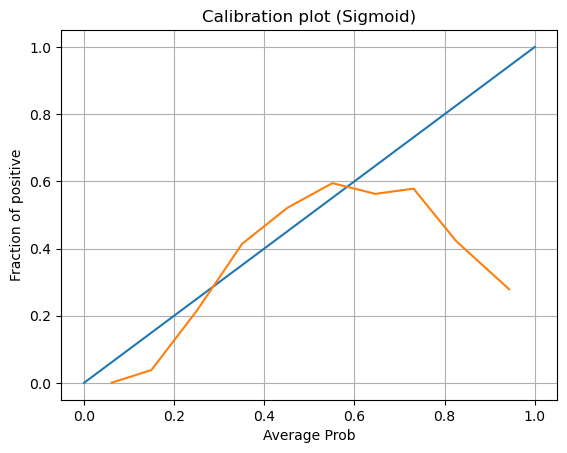

In [74]:
clf = SGDClassifier(penalty = 'l2',alpha = 0.0001,tol = 0.01,loss = 'log_loss')
calibrated_model = CalibratedClassifierCV(clf,method = 'sigmoid',cv = 5)
calibrated_model.fit(X_train,y_train)
prob = calibrated_model.predict_proba(X_test)[:,1] #for one of the class
fop,apv  = calibration_curve(y_test,prob,n_bins = 10,normalize = True)
plt.plot([0,1],[0,1])
plt.plot(apv,fop)
plt.grid()
plt.xlabel("Average Prob")
plt.ylabel("Fraction of positive")
plt.title('Calibration plot (Sigmoid)')
plt.show()

# MLOP's --- Model Experiment Tracking

* MLOps, short for Machine Learning Operations, refers to the practices and tools used to streamline and operationalize machine learning models in production environments. 
* It combines elements of machine learning, software engineering, and operations to ensure the reliable and efficient deployment, monitoring, and management of machine learning systems or models.

> The primary goal of MLOps is to bridge the gap between the development and deployment of machine learning models, enabling organizations to scale their ML initiatives and derive value from their models in real-world scenarios.

In [5]:
#pip install mlflow

## Experiment Tracking - 1 GradientBoostingClassifier

In [15]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier#GBDT,ADABOOST,STACKING,
from sklearn import metrics

mlflow.autolog()
#Separating the input and output variables.
y = df['is_duplicate'] 
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
        'fuzz_token_sort_ratio','fuzz_partial_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

#Separating the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.80, random_state = 20)


#Rescaling the train Numerical data
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train),
                                      columns= X_train.columns,
                                      index= X_train.index)

#Rescaling the test Numerical data.
X_test_transformed = pd.DataFrame(scaler.transform(X_test), 
                                   columns = X_test.columns, 
                                   index = X_test.index)

#Training and Testing the data
classifier = GradientBoostingClassifier()
classifier.fit(X_train_transformed, y_train)
y_test_predicted = classifier.predict(X_test_transformed)
acc = metrics.accuracy_score(y_test, y_test_predicted)
f1 = metrics.f1_score(y_test, y_test_predicted)

2023/06/07 15:02:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/07 15:02:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/07 15:02:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '934b6f63d0ab47af9e61222375eb442a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


## Experiment Tracking - 2 AdaBoostClassifier

In [16]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier#GBDT,ADABOOST,STACKING,
from sklearn import metrics

mlflow.autolog()
#Separating the input and output variables.
y = df['is_duplicate'] 
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
        'fuzz_token_sort_ratio','fuzz_partial_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

#Separating the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.80, random_state = 20)


#Rescaling the train Numerical data
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train),
                                      columns= X_train.columns,
                                      index= X_train.index)

#Rescaling the test Numerical data.
X_test_transformed = pd.DataFrame(scaler.transform(X_test), 
                                   columns = X_test.columns, 
                                   index = X_test.index)

#Training and Testing the data
classifier1 = AdaBoostClassifier()
classifier1.fit(X_train_transformed, y_train)
y_test_predicted = classifier1.predict(X_test_transformed)
acc = metrics.accuracy_score(y_test, y_test_predicted)
f1 = metrics.f1_score(y_test, y_test_predicted)

2023/06/07 15:09:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/07 15:09:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/07 15:09:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a8eda69b900a48628ecde750cf3766ea', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


## Experiment Tracking - 3 XGBClassifier

In [18]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier#GBDT,ADABOOST,STACKING,
from sklearn import metrics

mlflow.autolog()
#Separating the input and output variables.
y = df['is_duplicate'] 
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
        'fuzz_token_sort_ratio','fuzz_partial_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

#Separating the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.80, random_state = 20)


#Rescaling the train Numerical data
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train),
                                      columns= X_train.columns,
                                      index= X_train.index)

#Rescaling the test Numerical data.
X_test_transformed = pd.DataFrame(scaler.transform(X_test), 
                                   columns = X_test.columns, 
                                   index = X_test.index)

#Training and Testing the data
classifier2 = XGBClassifier()
classifier2.fit(X_train_transformed, y_train)
y_test_predicted = classifier1.predict(X_test_transformed)
acc = metrics.accuracy_score(y_test, y_test_predicted)
f1 = metrics.f1_score(y_test, y_test_predicted)

2023/06/07 15:43:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/07 15:43:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/07 15:43:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a344bb4b878a423fb4056120a876337b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


## Experiment Tracking - 4 StackingClassifier

In [19]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import metrics

mlflow.autolog()
#Separating the input and output variables.
y = df['is_duplicate'] 
X = df[['len_q1','len_q2','common_words','fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
        'fuzz_token_sort_ratio','fuzz_partial_token_sort_ratio','canberra_distance', 'cosine_distance','cityblock_distance','euclidean_distance',
                'minkowski_distance']]

#Separating the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.80, random_state = 20)


#Rescaling the train Numerical data
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train),
                                      columns= X_train.columns,
                                      index= X_train.index)

#Rescaling the test Numerical data.
X_test_transformed = pd.DataFrame(scaler.transform(X_test), 
                                   columns = X_test.columns, 
                                   index = X_test.index)

estimators = [
    ('LR', LogisticRegression()),
    ("GNB",GaussianNB()),
    ('DT',DecisionTreeClassifier(random_state=42),
    'XGb',XGBClassifier())
]

stack_cls = StackingClassifier(estimators=estimators,
                                      final_estimator=DecisionTreeClassifier())
#Training and Testing the data
stack_cls.fit(X_train_transformed, y_train)
y_test_predicted = stack_cls.predict(X_test_transformed)
acc = metrics.accuracy_score(y_test, y_test_predicted)
f1 = metrics.f1_score(y_test, y_test_predicted)

2023/06/07 16:02:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/07 16:02:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/07 16:02:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2148530c552a4ee4ad0ea5afb664e1b8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/07 16:02:10 WARNING mlflow.utils: Truncated the value of the key `estimators`. Truncated value: `[('LR', LogisticRegression()), ('GNB', GaussianNB()), ('DT', DecisionTreeClassifier(random_state=42), 'XGb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_ty

## XgBoost Mlflow  Model Tracking Images

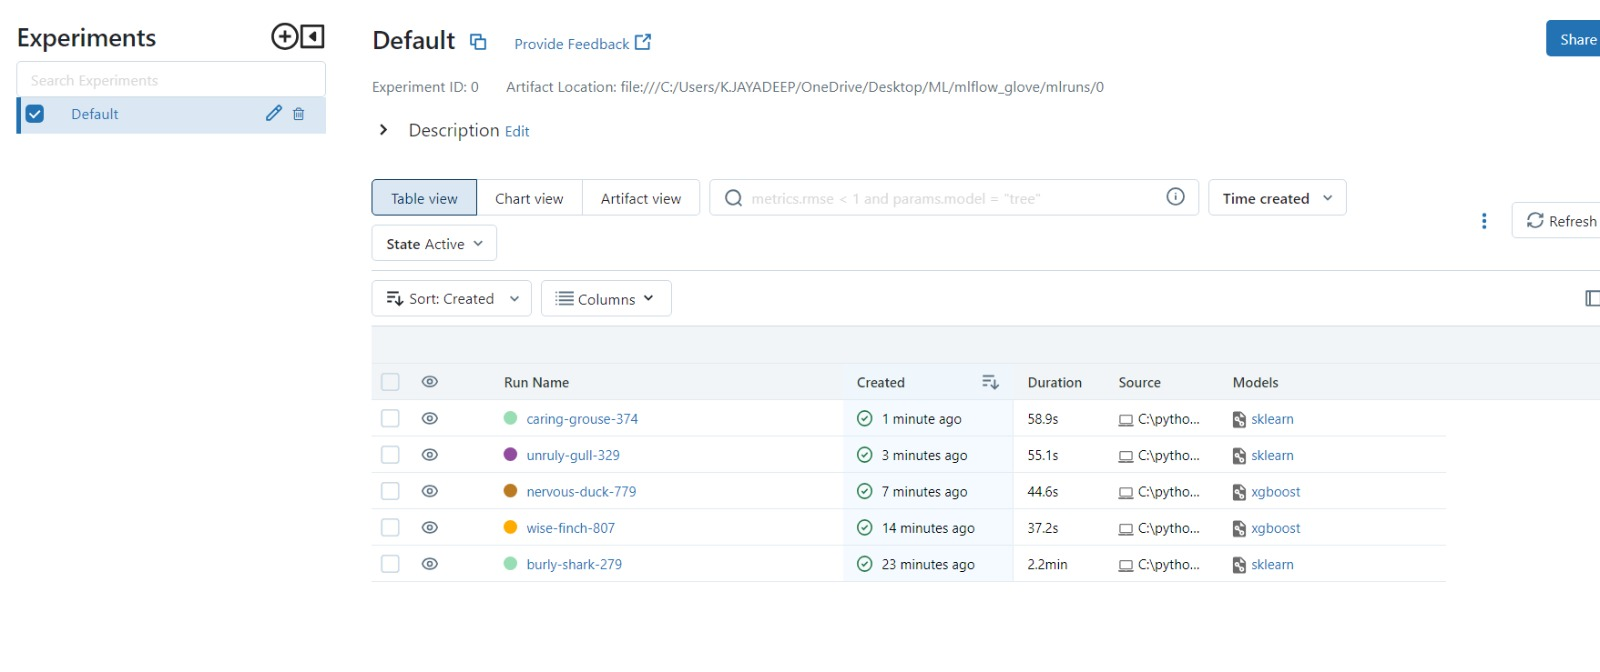

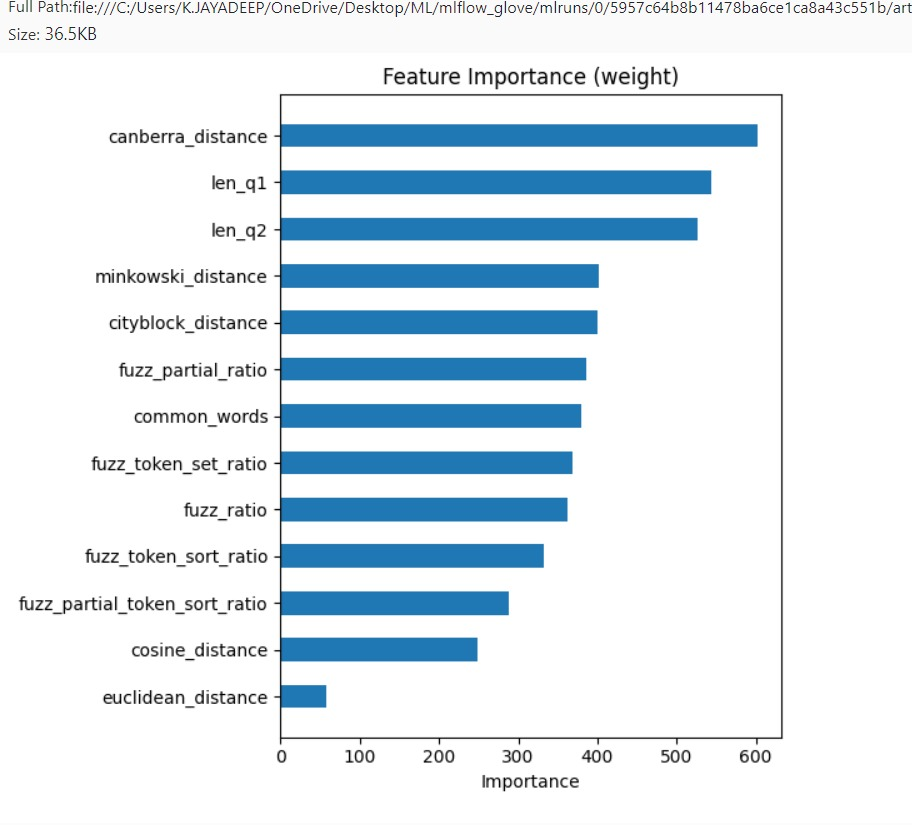

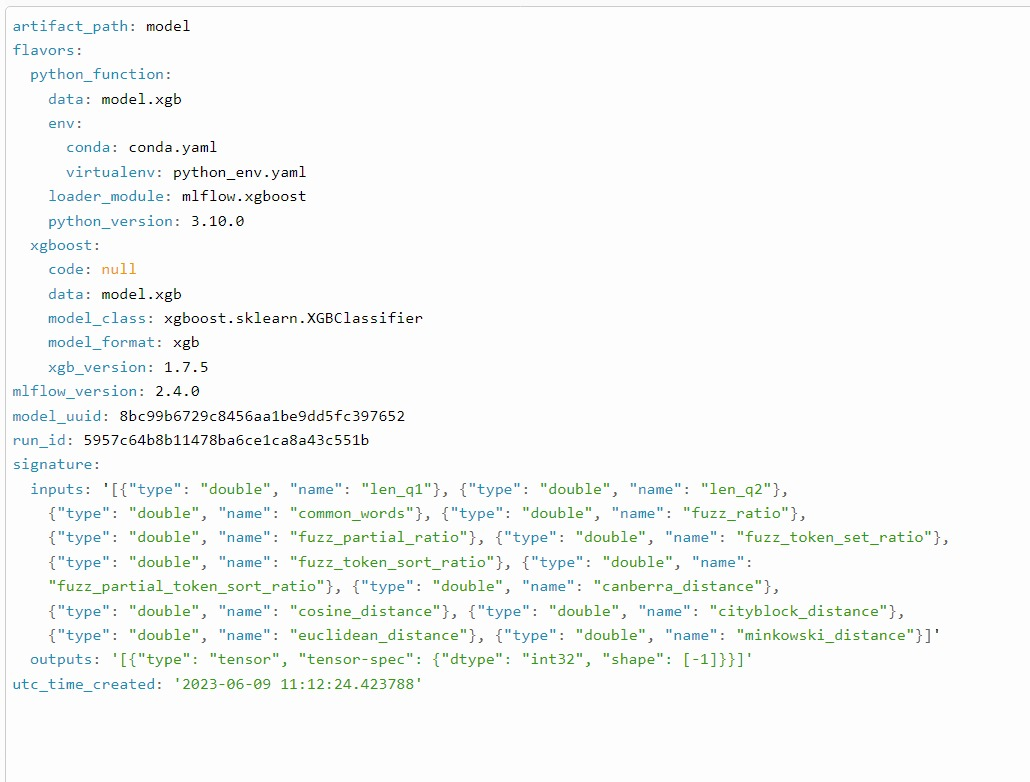

# Conclusions:

- From all the models that we built, The Model Generated by `XgBoostClassifier` Algorithem is the best `Model` for Quora Question Pair SImilarity Problem.
- Evaluation Metric - F1 score on train - `non - duplicates is 82% and duplicates is 71%`
- Evaluation Metric - F1 score on test -  `non - duplicates is 80% and duplicates is 69%`
- Our model is predicting well the non duplicate questions with label 0 and was lacking in the prediction of duplicate questions with label 1, which you can notice from the f1 score.(There is a cost of mis-classification)
- Reason for mis-classification: Due to data imbalance(68% non-duplicates, 36% duplicates).
- We have performed mlops for model tracking using mlflow for all the models and here you can the mlflow experiment tracking for XgboostClassifier model